In [1]:
# !pip install shap

In [1]:
import pandas as pd
import numpy as np
import random
import os
import math
from tqdm import tqdm

import matplotlib
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, accuracy_score

/home/user/anaconda3/envs/bsh/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Utils & preprocess

X = (batch, sequence, dimension)<br>
dimension은 feature 수 , sequence는 timestamp

y = (0,1) <br>
0 = healthy, 1 = failure

In [2]:
def extract_sequences(df, sequence_length, stride = 1 , next_time = True ):
    data_x = []
    assign_nums = df['배정번호'].unique()
    for assign_num in tqdm(assign_nums, total=len(assign_nums), desc='배정번호 별로 추출하는중'):
        sampled_labeled_df = df[df['배정번호']==assign_num]
        sampled_labeled_df = sampled_labeled_df.reset_index(drop=True)
        start_idx = 0
        while start_idx + sequence_length <= len(sampled_labeled_df):
            end_idx = start_idx + sequence_length
            sub_df = sampled_labeled_df.iloc[start_idx:end_idx]
            time_diff = (sub_df['TAG_MIN'].max() - sub_df['TAG_MIN'].min()).seconds
            if time_diff == sequence_length - 1:
                sequence = sub_df.drop(columns=['TAG_MIN', '배정번호','불량여부']).values
                data_x.append(sequence)
                if next_time == True:
                    start_idx = end_idx
                else:
                    start_idx += stride
            else:
                start_idx += stride
    return np.stack(data_x, axis=0)

In [3]:
def make_dataset(data , quality, threshold = 0.1, sequence_length = 60, downsampling = 2000):

    quality['불량률'] = quality['불량수량']/ quality['총수량'] * 100
    quality['불량여부'] = quality['불량률'].apply(lambda x: 1 if x > threshold else 0)
    labeled_df = data.merge(quality[['배정번호','불량여부']], on='배정번호', how='left')
    labeled_df['TAG_MIN'] =pd.to_datetime(labeled_df.TAG_MIN, format='%Y-%m-%d %H:%M:%S')
    labeled_df = labeled_df.dropna() # 지금은 결측치가 있는 행을 제거
    labeled_df_healthy = labeled_df[labeled_df['불량여부']==0]
    labeled_df_failure = labeled_df[labeled_df['불량여부']==1]
    healthy_x = extract_sequences(labeled_df_healthy, sequence_length , stride = 1, next_time = True)
    failure_x = extract_sequences(labeled_df_failure, sequence_length , stride = 1, next_time = True)
    random_indices = np.random.choice(healthy_x.shape[0], downsampling, replace=False)
    healthy_x = healthy_x[random_indices]
    healthy_y = np.zeros(len(healthy_x))
    failure_y = np.ones(len(failure_x))
    x_data = np.concatenate((healthy_x, failure_x), axis=0)
    y_data = np.concatenate((healthy_y, failure_y), axis=0)
    x_data, y_data = shuffle(x_data, y_data, random_state=42)
    return x_data, y_data

In [4]:
def Scaler_split(x_data, y_data,sequence_length = 60):

    number = list(range(1, len(x_data)))
    random.shuffle(number)
    train_ratio = 0.6
    valid_ratio = 0.2

    total_len = len(x_data)
    train_len = int(total_len * train_ratio)
    valid_len = int(total_len * valid_ratio)

    train_num = number[:train_len]
    valid_num = number[train_len:train_len+valid_len]
    test_num = number[train_len+valid_len:]

    X_train = x_data[train_num].reshape((-1,19))
    X_valid = x_data[valid_num].reshape((-1,19))
    X_test = x_data[test_num].reshape((-1,19))

    y_train = y_data[train_num]
    y_valid = y_data[valid_num]
    y_test = y_data[test_num]

    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train = scaler.transform(X_train).reshape((-1,sequence_length,19))
    X_valid = scaler.transform(X_valid).reshape((-1,sequence_length,19))
    X_test = scaler.transform(X_test).reshape((-1,sequence_length,19))

    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [5]:
class MyDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = torch.tensor(x_data, dtype=torch.float32)
        self.y_data = torch.tensor(y_data, dtype=torch.float32)

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

In [6]:
def plot_losses(train_losses, valid_losses, epochs):
    plt.figure(figsize=(5, 3))

    # epochs가 int 타입이라면 range로 리스트 생성
    if isinstance(epochs, int):
        epochs = list(range(1, epochs+1))

    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, valid_losses, label='Validation Loss')
    plt.title('Train and Validation Losses over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [7]:
def plot_accuracies(train_accuracies, valid_accuracies, epochs):
    plt.figure(figsize=(5, 3))

    # epochs가 int 타입이라면 range로 리스트 생성
    if isinstance(epochs, int):
        epochs = list(range(1, epochs+1))

    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, valid_accuracies, label='Validation Accuracy')
    plt.title('Train and Validation Accuracies over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [8]:
def test(model, test_loader):
    model.eval()

    all_labels = []
    all_probabilities = []

    with torch.no_grad():
        for batch in tqdm(test_loader):
            x_data_batch, y_data_batch = batch

            x_data_batch = x_data_batch.to(device)
            y_data_batch = y_data_batch.to(device)

            probabilities = model(x_data_batch)[:, 1]
            all_probabilities.extend(probabilities.cpu().numpy())
            all_labels.extend(y_data_batch.cpu().numpy())

    all_predictions = [1 if prob > 0.5 else 0 for prob in all_probabilities]

    f1 = f1_score(all_labels, all_predictions, average='macro')
    auroc = roc_auc_score(all_labels, all_probabilities)
    accuracy = accuracy_score(all_labels, all_predictions)

    return f1, auroc, accuracy, all_labels, all_probabilities

In [9]:
def plot_roc_curve(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.plot(fpr, tpr, linestyle='-', label='Model')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

# Model

In [10]:
class LSTM(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.hidden_size = config.hidden_size
        self.lstm = nn.LSTM(config.input_size, config.hidden_size, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(config.hidden_size, config.hidden_size//2),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(config.hidden_size//2, config.output_size)
        )
        self.actv = nn.ReLU()

    def forward(self, x):
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size, x.device)
        lstm_out, hidden = self.lstm(x, hidden)
        last_output = lstm_out[:, -1, :]
        output = self.actv(self.fc(last_output))

        return output.squeeze(1)

    def init_hidden(self, batch_size, device):
        return (torch.zeros(1, batch_size, self.hidden_size, device=device),
                torch.zeros(1, batch_size, self.hidden_size, device=device))

# trainer 구현

In [11]:
class Trainer():
  def __init__(self, model, optimizer, loss_function, device):
    super().__init__()
    self.model = model
    self.optimizer = optimizer
    self.loss_function = loss_function
    self.device = device

  def train(self, train_loader, config):
    self.model.train()

    total_loss = 0
    total_correct = 0

    batch_size = train_loader.batch_size
    total_dataset_size = len(train_loader.dataset)
    num_batches = math.ceil(total_dataset_size / batch_size)

    for batch in tqdm( train_loader, total = num_batches ):
      self.optimizer.zero_grad()

      x_data_batch, y_data_batch = batch

      x_data_batch = x_data_batch.to(self.device)
      y_data_batch = y_data_batch.to(self.device)

      outputs = self.model(x_data_batch)
      loss = self.loss_function(outputs, y_data_batch.long())
      total_loss += loss.item()

      #역전파
      loss.backward()
      self.optimizer.step()

      _, predicted = torch.max(outputs, 1)  # 확률이 가장 높은 클래스를 선택
      correct = (predicted == y_data_batch).sum().item()
      total_correct += correct

    avg_loss = total_loss / total_dataset_size
    accuracy = total_correct / total_dataset_size

    return avg_loss, accuracy

  def valid(self, valid_loader, config):
    self.model.eval()  # 모델을 평가 모드로 전환

    total_loss = 0
    total_correct = 0

    batch_size = valid_loader.batch_size
    total_dataset_size = len(valid_loader.dataset)
    num_batches = math.ceil(total_dataset_size / batch_size)

    with torch.no_grad():  # 그래디언트 계산을 비활성화
        for batch in tqdm(valid_loader, total=num_batches):
            x_data_batch, y_data_batch = batch

            x_data_batch = x_data_batch.to(self.device)
            y_data_batch = y_data_batch.to(self.device)

            outputs = self.model(x_data_batch)
            loss = self.loss_function(outputs, y_data_batch.long())
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)  # 확률이 가장 높은 클래스를 선택
            correct = (predicted == y_data_batch).sum().item()
            total_correct += correct

    avg_loss = total_loss / total_dataset_size
    accuracy = total_correct / total_dataset_size

    return avg_loss, accuracy

  def test(self, test_loader, config):
    self.model.eval()  # 모델을 평가 모드로 전환

    total_loss = 0
    total_correct = 0

    batch_size = test_loader.batch_size
    total_dataset_size = len(test_loader.dataset)
    num_batches = math.ceil(total_dataset_size / batch_size)

    with torch.no_grad():  # 그래디언트 계산을 비활성화
        for batch in tqdm(test_loader, total=num_batches):
            x_data_batch, y_data_batch = batch

            x_data_batch = x_data_batch.to(self.device)
            y_data_batch = y_data_batch.to(self.device)

            outputs = self.model(x_data_batch)
            loss = self.loss_function(outputs, y_data_batch.long())
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)  # 확률이 가장 높은 클래스를 선택
            correct = (predicted == y_data_batch).sum().item()
            total_correct += correct

    avg_loss = total_loss / total_dataset_size
    accuracy = total_correct / total_dataset_size

    return avg_loss, accuracy

  def save_model(self, epoch, path="model_checkpoint"):
    model_path = f"{path}_epoch_{epoch}.pth"
    torch.save(self.model.state_dict(), model_path)
    print(f"Model saved")
    
  def save_best_model(self, path="model_checkpoint"):
    model_path = f"{path}_best_model.pth"
    torch.save(self.model.state_dict(), model_path)
    print(f"Model saved")

# Main

In [12]:
class Config():
  threshold = 0.1        # 불량률을 몇 퍼센트까지 0.1로 정의할 것인지
  sequence_length = 60   # 몇초를 하나의 instance로 볼 것인지
  downsampling = 2000    # healthy data를 몇개를 쓸지
  EPOCH = 200
  LEARNING_RATE = 0.001
  BATCH_SIZE = 256
  SEED = 42
  input_size = 19        # 처음 input의 차원의 개수 (feature수와 같다)
  hidden_size=512        # LSTM hidden vector size
  output_size = 2        # output 차원의 개수

config = Config()

In [13]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(config.SEED) # Seed 고정

In [14]:
df = pd.read_csv('/home/user/Desktop/bsh/absoluteA/data/data.csv',encoding = 'cp949')
quality = pd.read_excel('/home/user/Desktop/bsh/absoluteA/data/quality.xlsx')

In [15]:
# 정의한 기준에 맞게 label하고 정해준 시간만큼 split하고 dataset만들기
x_data, y_data = make_dataset(df,quality , threshold = config.threshold, sequence_length = config.sequence_length, downsampling = config.downsampling )

배정번호 별로 추출하는중: 100%|██████████| 7/7 [00:03<00:00,  1.92it/s]


In [16]:
print('healthy(0)의 개수 :',int(len(y_data)-y_data.sum()))
print('failure(1)의 개수 :',int(y_data.sum()))

healthy(0)의 개수 : 2000
failure(1)의 개수 : 1569


In [17]:
X_train, X_valid, X_test, y_train, y_valid, y_test = Scaler_split(x_data, y_data, sequence_length = config.sequence_length)

In [18]:
# 인스턴스 생성
train_dataset = MyDataset(X_train, y_train)
valid_dataset = MyDataset(X_valid, y_valid)
test_dataset = MyDataset(X_test, y_test)

del X_train, X_valid, X_test, y_train, y_valid, y_test

In [19]:
# batch로 분할
train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=True)

In [20]:
#데이터 수 확인
total_train_data = len(train_loader.dataset)
print(f"Total number of data samples in train_loader: {total_train_data}")
total_valid_data = len(valid_loader.dataset)
print(f"Total number of data samples in valid_loader: {total_valid_data}")
total_test_data = len(test_loader.dataset)
print(f"Total number of data samples in test_loader: {total_test_data}")

Total number of data samples in train_loader: 2141
Total number of data samples in valid_loader: 713
Total number of data samples in test_loader: 714


In [21]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [22]:
# model, optimizer, loss_function 구현하고 결합시키기
model = LSTM(config)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
loss_function = nn.CrossEntropyLoss()
trainer = Trainer(model, optimizer, loss_function, device)

In [23]:
# save path 지정 잘해줄 것!!!!!!!!(일단 지금은 저장하지 말자)
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
valid_accuracy_save = 0
best_epoch_save = 0 

for epoch in range(config.EPOCH):
    print('=====================================================================================')
    print("epoch {}".format(epoch+1))

    train_loss, train_accuracy = trainer.train(train_loader, config)
    valid_loss, valid_accuracy = trainer.valid(valid_loader, config)
    if valid_accuracy_save < valid_accuracy :
      trainer.save_best_model(path = '/home/user/Desktop/bsh/absoluteA/model/2000_LSTM') # 이 부분!!!!
      valid_accuracy_save = valid_accuracy
      best_epoch_save = epoch + 1

    # 결과값을 리스트에 추가
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)

    print("TRAIN LOSS = {}, TRAIN ACC = {}, ".format(train_loss, train_accuracy))
    print("VALID LOSS = {}, VALID ACC = {}, ".format(valid_loss, valid_accuracy))

epoch 1


100%|██████████| 3/3 [00:00<00:00, 491.89it/s]


Model saved
TRAIN LOSS = 0.002786519008504626, TRAIN ACC = 0.6347501167678655, 
VALID LOSS = 0.0025618822845469686, VALID ACC = 0.6928471248246845, 
epoch 2


100%|██████████| 3/3 [00:00<00:00, 514.15it/s]


TRAIN LOSS = 0.0025477476177901545, TRAIN ACC = 0.6912657636618402, 
VALID LOSS = 0.0024888900854477206, VALID ACC = 0.6802244039270687, 
epoch 3


100%|██████████| 3/3 [00:00<00:00, 508.79it/s]


Model saved
TRAIN LOSS = 0.002460504791993841, TRAIN ACC = 0.6809901914992994, 
VALID LOSS = 0.0023622555451841207, VALID ACC = 0.7082748948106592, 
epoch 4


100%|██████████| 3/3 [00:00<00:00, 528.92it/s]


TRAIN LOSS = 0.0023541839141703164, TRAIN ACC = 0.7029425502101821, 
VALID LOSS = 0.0022773036281323535, VALID ACC = 0.7026647966339411, 
epoch 5


100%|██████████| 3/3 [00:00<00:00, 534.69it/s]


TRAIN LOSS = 0.00222898335559298, TRAIN ACC = 0.7174217655301262, 
VALID LOSS = 0.0022191620976526973, VALID ACC = 0.7054698457223001, 
epoch 6


100%|██████████| 3/3 [00:00<00:00, 535.40it/s]


Model saved
TRAIN LOSS = 0.0021649441363821515, TRAIN ACC = 0.7356375525455394, 
VALID LOSS = 0.0021519649246130217, VALID ACC = 0.7475455820476858, 
epoch 7


100%|██████████| 3/3 [00:00<00:00, 529.03it/s]


Model saved
TRAIN LOSS = 0.00203238560573234, TRAIN ACC = 0.7585240541802896, 
VALID LOSS = 0.002053684890688218, VALID ACC = 0.7503506311360448, 
epoch 8


100%|██████████| 3/3 [00:00<00:00, 530.30it/s]


Model saved
TRAIN LOSS = 0.0018993136288127516, TRAIN ACC = 0.760859411489958, 
VALID LOSS = 0.0020773271608152026, VALID ACC = 0.7601683029453016, 
epoch 9


100%|██████████| 3/3 [00:00<00:00, 530.66it/s]


Model saved
TRAIN LOSS = 0.0019037067500412435, TRAIN ACC = 0.7641289117234937, 
VALID LOSS = 0.0018828612808425497, VALID ACC = 0.7629733520336606, 
epoch 10


100%|██████████| 3/3 [00:00<00:00, 529.47it/s]


TRAIN LOSS = 0.001808850885495467, TRAIN ACC = 0.7706679121905652, 
VALID LOSS = 0.0018446641082014643, VALID ACC = 0.7629733520336606, 
epoch 11


100%|██████████| 3/3 [00:00<00:00, 535.01it/s]


TRAIN LOSS = 0.0018371601825225917, TRAIN ACC = 0.7664642690331621, 
VALID LOSS = 0.0018826788304397133, VALID ACC = 0.7517531556802244, 
epoch 12


100%|██████████| 3/3 [00:00<00:00, 537.57it/s]


TRAIN LOSS = 0.0017624351255585244, TRAIN ACC = 0.7697337692666978, 
VALID LOSS = 0.0017851426842169207, VALID ACC = 0.7629733520336606, 
epoch 13


100%|██████████| 3/3 [00:00<00:00, 543.00it/s]


Model saved
TRAIN LOSS = 0.0017120830926979774, TRAIN ACC = 0.7725361980382999, 
VALID LOSS = 0.0018366145970610717, VALID ACC = 0.7727910238429172, 
epoch 14


100%|██████████| 3/3 [00:00<00:00, 528.05it/s]


TRAIN LOSS = 0.0017957454081842243, TRAIN ACC = 0.7575899112564223, 
VALID LOSS = 0.002023970428723607, VALID ACC = 0.7419354838709677, 
epoch 15


100%|██████████| 3/3 [00:00<00:00, 536.17it/s]


TRAIN LOSS = 0.0018146447993950664, TRAIN ACC = 0.7529191966370855, 
VALID LOSS = 0.0019463017311203196, VALID ACC = 0.7545582047685835, 
epoch 16


100%|██████████| 3/3 [00:00<00:00, 528.83it/s]


TRAIN LOSS = 0.0017959681669722535, TRAIN ACC = 0.7561886968706212, 
VALID LOSS = 0.0018492242397131792, VALID ACC = 0.7391304347826086, 
epoch 17


100%|██████████| 3/3 [00:00<00:00, 540.74it/s]


Model saved
TRAIN LOSS = 0.0016507561632207151, TRAIN ACC = 0.7748715553479683, 
VALID LOSS = 0.0017519512149762639, VALID ACC = 0.7812061711079944, 
epoch 18


100%|██████████| 3/3 [00:00<00:00, 509.51it/s]


Model saved
TRAIN LOSS = 0.0014714527943044107, TRAIN ACC = 0.8290518449322747, 
VALID LOSS = 0.0015569520698857674, VALID ACC = 0.8274894810659187, 
epoch 19


100%|██████████| 3/3 [00:00<00:00, 522.11it/s]


TRAIN LOSS = 0.0013734042950736647, TRAIN ACC = 0.8766931340495095, 
VALID LOSS = 0.0015825860797940932, VALID ACC = 0.8246844319775596, 
epoch 20


100%|██████████| 3/3 [00:00<00:00, 531.10it/s]


TRAIN LOSS = 0.0014494417399683048, TRAIN ACC = 0.8594114899579636, 
VALID LOSS = 0.0015963856418203003, VALID ACC = 0.8246844319775596, 
epoch 21


100%|██████████| 3/3 [00:00<00:00, 536.77it/s]


TRAIN LOSS = 0.0014519253271531413, TRAIN ACC = 0.844465203176086, 
VALID LOSS = 0.0016134192365081916, VALID ACC = 0.8218793828892006, 
epoch 22


100%|██████████| 3/3 [00:00<00:00, 535.47it/s]


TRAIN LOSS = 0.0013779040420795923, TRAIN ACC = 0.8636151331153666, 
VALID LOSS = 0.0017088592303250649, VALID ACC = 0.8134642356241234, 
epoch 23


100%|██████████| 3/3 [00:00<00:00, 534.58it/s]


TRAIN LOSS = 0.0015226295344019983, TRAIN ACC = 0.8491359177954227, 
VALID LOSS = 0.0017689193532309726, VALID ACC = 0.8120617110799438, 
epoch 24


100%|██████████| 3/3 [00:00<00:00, 537.85it/s]


TRAIN LOSS = 0.0014571555581732033, TRAIN ACC = 0.85007006071929, 
VALID LOSS = 0.0016399172211763401, VALID ACC = 0.7994389901823282, 
epoch 25


100%|██████████| 3/3 [00:00<00:00, 534.28it/s]


TRAIN LOSS = 0.0012993207466708116, TRAIN ACC = 0.8720224194301728, 
VALID LOSS = 0.0016178274305137645, VALID ACC = 0.8190743338008415, 
epoch 26


100%|██████████| 3/3 [00:00<00:00, 533.02it/s]


TRAIN LOSS = 0.0012276619463978055, TRAIN ACC = 0.8729565623540402, 
VALID LOSS = 0.0015496904184574166, VALID ACC = 0.8176718092566619, 
epoch 27


100%|██████████| 3/3 [00:00<00:00, 542.04it/s]


TRAIN LOSS = 0.0011865920215385754, TRAIN ACC = 0.8785614198972442, 
VALID LOSS = 0.0016449535628689288, VALID ACC = 0.8218793828892006, 
epoch 28


100%|██████████| 3/3 [00:00<00:00, 532.43it/s]


Model saved
TRAIN LOSS = 0.0011649471766366295, TRAIN ACC = 0.8860345632881831, 
VALID LOSS = 0.0015053959330870426, VALID ACC = 0.8302945301542777, 
epoch 29


100%|██████████| 3/3 [00:00<00:00, 524.29it/s]


Model saved
TRAIN LOSS = 0.0010490933766380641, TRAIN ACC = 0.8981784212984587, 
VALID LOSS = 0.0016825307385282798, VALID ACC = 0.8330995792426368, 
epoch 30


100%|██████████| 3/3 [00:00<00:00, 527.94it/s]


Model saved
TRAIN LOSS = 0.0010652790513343757, TRAIN ACC = 0.897711349836525, 
VALID LOSS = 0.0016090432273388577, VALID ACC = 0.8429172510518934, 
epoch 31


100%|██████████| 3/3 [00:00<00:00, 536.49it/s]


Model saved
TRAIN LOSS = 0.001059030864295532, TRAIN ACC = 0.8963101354507239, 
VALID LOSS = 0.0015707750808640918, VALID ACC = 0.8485273492286115, 
epoch 32


100%|██████████| 3/3 [00:00<00:00, 524.03it/s]


TRAIN LOSS = 0.0010980612579654834, TRAIN ACC = 0.9009808500700607, 
VALID LOSS = 0.0016460092254975734, VALID ACC = 0.8288920056100981, 
epoch 33


100%|██████████| 3/3 [00:00<00:00, 533.26it/s]


Model saved
TRAIN LOSS = 0.0009709618696816777, TRAIN ACC = 0.9023820644558618, 
VALID LOSS = 0.0014276125195317314, VALID ACC = 0.8499298737727911, 
epoch 34


100%|██████████| 3/3 [00:00<00:00, 526.39it/s]


TRAIN LOSS = 0.0010087205491184019, TRAIN ACC = 0.9042503503035965, 
VALID LOSS = 0.0015140589206449448, VALID ACC = 0.8401122019635343, 
epoch 35


100%|██████████| 3/3 [00:00<00:00, 531.98it/s]


Model saved
TRAIN LOSS = 0.0009561242663598628, TRAIN ACC = 0.9051844932274637, 
VALID LOSS = 0.0014300779406853845, VALID ACC = 0.85273492286115, 
epoch 36


100%|██████████| 3/3 [00:00<00:00, 526.42it/s]


TRAIN LOSS = 0.0009025035200693628, TRAIN ACC = 0.9177954226996731, 
VALID LOSS = 0.0014441652435072676, VALID ACC = 0.85273492286115, 
epoch 37


100%|██████████| 3/3 [00:00<00:00, 520.92it/s]


Model saved
TRAIN LOSS = 0.0008592945303887978, TRAIN ACC = 0.914992993928071, 
VALID LOSS = 0.0014168573295250848, VALID ACC = 0.8611500701262272, 
epoch 38


100%|██████████| 3/3 [00:00<00:00, 534.10it/s]


TRAIN LOSS = 0.0008099319944867237, TRAIN ACC = 0.9266697804764129, 
VALID LOSS = 0.0013840241151304097, VALID ACC = 0.8597475455820477, 
epoch 39


100%|██████████| 3/3 [00:00<00:00, 534.87it/s]


TRAIN LOSS = 0.0007640651485063605, TRAIN ACC = 0.9332087809434844, 
VALID LOSS = 0.0015838504004779405, VALID ACC = 0.8513323983169705, 
epoch 40


100%|██████████| 3/3 [00:00<00:00, 531.01it/s]


TRAIN LOSS = 0.0007856350282484658, TRAIN ACC = 0.9299392807099486, 
VALID LOSS = 0.001555556209358226, VALID ACC = 0.8555399719495091, 
epoch 41


100%|██████████| 3/3 [00:00<00:00, 532.27it/s]


TRAIN LOSS = 0.0008620672947555322, TRAIN ACC = 0.9182624941616068, 
VALID LOSS = 0.0016439030832528733, VALID ACC = 0.844319775596073, 
epoch 42


100%|██████████| 3/3 [00:00<00:00, 536.88it/s]


TRAIN LOSS = 0.00086848380018873, TRAIN ACC = 0.9210649229332087, 
VALID LOSS = 0.001528758278735724, VALID ACC = 0.847124824684432, 
epoch 43


100%|██████████| 3/3 [00:00<00:00, 536.81it/s]


Model saved
TRAIN LOSS = 0.0007687799775227382, TRAIN ACC = 0.929472209248015, 
VALID LOSS = 0.001364168871669582, VALID ACC = 0.8695652173913043, 
epoch 44


100%|██████████| 3/3 [00:00<00:00, 528.07it/s]


TRAIN LOSS = 0.0007680336110005029, TRAIN ACC = 0.930873423633816, 
VALID LOSS = 0.0015738305921808701, VALID ACC = 0.8695652173913043, 
epoch 45


100%|██████████| 3/3 [00:00<00:00, 535.44it/s]


TRAIN LOSS = 0.0007553843625624121, TRAIN ACC = 0.9332087809434844, 
VALID LOSS = 0.001722198967177938, VALID ACC = 0.8555399719495091, 
epoch 46


100%|██████████| 3/3 [00:00<00:00, 534.10it/s]


TRAIN LOSS = 0.0007077852374535195, TRAIN ACC = 0.9383465670247548, 
VALID LOSS = 0.0014432416641026694, VALID ACC = 0.8667601683029453, 
epoch 47


100%|██████████| 3/3 [00:00<00:00, 533.69it/s]


TRAIN LOSS = 0.000735725986517684, TRAIN ACC = 0.9378794955628211, 
VALID LOSS = 0.0014931365199711013, VALID ACC = 0.8597475455820477, 
epoch 48


100%|██████████| 3/3 [00:00<00:00, 514.68it/s]


TRAIN LOSS = 0.0006775858697630657, TRAIN ACC = 0.9392807099486221, 
VALID LOSS = 0.001554391034689391, VALID ACC = 0.8625525946704067, 
epoch 49


100%|██████████| 3/3 [00:00<00:00, 531.22it/s]


TRAIN LOSS = 0.0006421380500156486, TRAIN ACC = 0.9388136384866884, 
VALID LOSS = 0.0015360088953630788, VALID ACC = 0.8485273492286115, 
epoch 50


100%|██████████| 3/3 [00:00<00:00, 529.52it/s]


TRAIN LOSS = 0.0006736084289887084, TRAIN ACC = 0.9388136384866884, 
VALID LOSS = 0.0015585945832946692, VALID ACC = 0.8639551192145862, 
epoch 51


100%|██████████| 3/3 [00:00<00:00, 538.70it/s]


TRAIN LOSS = 0.0006429039112377924, TRAIN ACC = 0.9425502101821579, 
VALID LOSS = 0.001540185776532616, VALID ACC = 0.8611500701262272, 
epoch 52


100%|██████████| 3/3 [00:00<00:00, 533.97it/s]


Model saved
TRAIN LOSS = 0.0006572729631708583, TRAIN ACC = 0.946753853339561, 
VALID LOSS = 0.0014228424133124224, VALID ACC = 0.8737727910238429, 
epoch 53


100%|██████████| 3/3 [00:00<00:00, 527.28it/s]


TRAIN LOSS = 0.0007451734688726333, TRAIN ACC = 0.9397477814105558, 
VALID LOSS = 0.0016118067762126093, VALID ACC = 0.8653576437587658, 
epoch 54


100%|██████████| 3/3 [00:00<00:00, 533.72it/s]


Model saved
TRAIN LOSS = 0.0006641520344726619, TRAIN ACC = 0.9462867818776273, 
VALID LOSS = 0.0014463212513488942, VALID ACC = 0.8779803646563815, 
epoch 55


100%|██████████| 3/3 [00:00<00:00, 527.36it/s]


TRAIN LOSS = 0.0004687242832823036, TRAIN ACC = 0.9593647828117702, 
VALID LOSS = 0.0015676483449227011, VALID ACC = 0.8681626928471248, 
epoch 56


100%|██████████| 3/3 [00:00<00:00, 528.25it/s]


Model saved
TRAIN LOSS = 0.00036683281042318596, TRAIN ACC = 0.9677720691265763, 
VALID LOSS = 0.0015593391397724981, VALID ACC = 0.879382889200561, 
epoch 57


100%|██████████| 3/3 [00:00<00:00, 527.81it/s]


TRAIN LOSS = 0.0002913844572890868, TRAIN ACC = 0.9794488556749182, 
VALID LOSS = 0.0020793724026619805, VALID ACC = 0.8779803646563815, 
epoch 58


100%|██████████| 3/3 [00:00<00:00, 530.28it/s]


TRAIN LOSS = 0.00041477490061635674, TRAIN ACC = 0.9705744978981784, 
VALID LOSS = 0.0017774959015144037, VALID ACC = 0.8653576437587658, 
epoch 59


100%|██████████| 3/3 [00:00<00:00, 532.61it/s]


TRAIN LOSS = 0.0008611900019400702, TRAIN ACC = 0.93647828117702, 
VALID LOSS = 0.001952880437043071, VALID ACC = 0.8429172510518934, 
epoch 60


100%|██████████| 3/3 [00:00<00:00, 531.98it/s]


TRAIN LOSS = 0.0006351856178126008, TRAIN ACC = 0.9411489957963568, 
VALID LOSS = 0.0015114549166022645, VALID ACC = 0.8639551192145862, 
epoch 61


100%|██████████| 3/3 [00:00<00:00, 534.33it/s]


TRAIN LOSS = 0.0005128036267509086, TRAIN ACC = 0.9556282111163008, 
VALID LOSS = 0.001518025430021246, VALID ACC = 0.8583450210378681, 
epoch 62


100%|██████████| 3/3 [00:00<00:00, 539.71it/s]


TRAIN LOSS = 0.0005855537578637552, TRAIN ACC = 0.950957496496964, 
VALID LOSS = 0.001704911613865621, VALID ACC = 0.8653576437587658, 
epoch 63


100%|██████████| 3/3 [00:00<00:00, 61.29it/s]


TRAIN LOSS = 0.00047550428726582925, TRAIN ACC = 0.9621672115833723, 
VALID LOSS = 0.001490891397751732, VALID ACC = 0.8779803646563815, 
epoch 64


100%|██████████| 3/3 [00:00<00:00, 528.03it/s]


TRAIN LOSS = 0.00034851516827084873, TRAIN ACC = 0.9747781410555815, 
VALID LOSS = 0.0016649960217602958, VALID ACC = 0.8737727910238429, 
epoch 65


100%|██████████| 3/3 [00:00<00:00, 538.24it/s]


Model saved
TRAIN LOSS = 0.00031230791912547674, TRAIN ACC = 0.9738439981317142, 
VALID LOSS = 0.0017868788680388248, VALID ACC = 0.8821879382889201, 
epoch 66


100%|██████████| 3/3 [00:00<00:00, 532.72it/s]


TRAIN LOSS = 0.0005649399414261832, TRAIN ACC = 0.9691732835123774, 
VALID LOSS = 0.0022968130308983203, VALID ACC = 0.8513323983169705, 
epoch 67


100%|██████████| 3/3 [00:00<00:00, 536.15it/s]


TRAIN LOSS = 0.0008926257484151848, TRAIN ACC = 0.9346099953292853, 
VALID LOSS = 0.0020323117769115604, VALID ACC = 0.847124824684432, 
epoch 68


100%|██████████| 3/3 [00:00<00:00, 531.66it/s]


TRAIN LOSS = 0.0007622627622331764, TRAIN ACC = 0.932274638019617, 
VALID LOSS = 0.001718596188249628, VALID ACC = 0.8653576437587658, 
epoch 69


100%|██████████| 3/3 [00:00<00:00, 535.99it/s]


TRAIN LOSS = 0.0006715266929225129, TRAIN ACC = 0.946753853339561, 
VALID LOSS = 0.001663683214829647, VALID ACC = 0.8681626928471248, 
epoch 70


100%|██████████| 3/3 [00:00<00:00, 544.29it/s]


TRAIN LOSS = 0.00044698041978142965, TRAIN ACC = 0.964035497431107, 
VALID LOSS = 0.001869929622634096, VALID ACC = 0.8667601683029453, 
epoch 71


100%|██████████| 3/3 [00:00<00:00, 544.03it/s]


TRAIN LOSS = 0.00032909125409801113, TRAIN ACC = 0.9766464269033162, 
VALID LOSS = 0.0017725433657915027, VALID ACC = 0.8667601683029453, 
epoch 72


100%|██████████| 3/3 [00:00<00:00, 537.00it/s]


TRAIN LOSS = 0.0006881135471064262, TRAIN ACC = 0.9570294255021018, 
VALID LOSS = 0.0022001932747400827, VALID ACC = 0.8513323983169705, 
epoch 73


100%|██████████| 3/3 [00:00<00:00, 535.15it/s]


TRAIN LOSS = 0.0006970189188140289, TRAIN ACC = 0.9397477814105558, 
VALID LOSS = 0.0019073042010190945, VALID ACC = 0.8611500701262272, 
epoch 74


100%|██████████| 3/3 [00:00<00:00, 536.54it/s]


TRAIN LOSS = 0.000556476281965408, TRAIN ACC = 0.9579635684259692, 
VALID LOSS = 0.0016203949026773888, VALID ACC = 0.8555399719495091, 
epoch 75


100%|██████████| 3/3 [00:00<00:00, 537.48it/s]


TRAIN LOSS = 0.0004584694795383576, TRAIN ACC = 0.9612330686595049, 
VALID LOSS = 0.0018350629953649234, VALID ACC = 0.8667601683029453, 
epoch 76


100%|██████████| 3/3 [00:00<00:00, 540.62it/s]


TRAIN LOSS = 0.00042013849041719185, TRAIN ACC = 0.9677720691265763, 
VALID LOSS = 0.001968593617475384, VALID ACC = 0.8583450210378681, 
epoch 77


100%|██████████| 3/3 [00:00<00:00, 541.06it/s]


TRAIN LOSS = 0.0004919561244710925, TRAIN ACC = 0.9654367118169079, 
VALID LOSS = 0.0021980368071150814, VALID ACC = 0.844319775596073, 
epoch 78


100%|██████████| 3/3 [00:00<00:00, 541.64it/s]


TRAIN LOSS = 0.0005914503373536257, TRAIN ACC = 0.9490892106492294, 
VALID LOSS = 0.0020665966528160876, VALID ACC = 0.8681626928471248, 
epoch 79


100%|██████████| 3/3 [00:00<00:00, 541.81it/s]


TRAIN LOSS = 0.0004761265447238849, TRAIN ACC = 0.9588977113498365, 
VALID LOSS = 0.0016837094141089399, VALID ACC = 0.8541374474053296, 
epoch 80


100%|██████████| 3/3 [00:00<00:00, 539.07it/s]


TRAIN LOSS = 0.0003512363562456975, TRAIN ACC = 0.9710415693601121, 
VALID LOSS = 0.0017870509524164828, VALID ACC = 0.8709677419354839, 
epoch 81


100%|██████████| 3/3 [00:00<00:00, 534.44it/s]


TRAIN LOSS = 0.00027193005524300796, TRAIN ACC = 0.9789817842129845, 
VALID LOSS = 0.0018481222225606524, VALID ACC = 0.8737727910238429, 
epoch 82


100%|██████████| 3/3 [00:00<00:00, 539.00it/s]


TRAIN LOSS = 0.00022467500358360607, TRAIN ACC = 0.9836524988323213, 
VALID LOSS = 0.001899835312684154, VALID ACC = 0.8723702664796634, 
epoch 83


100%|██████████| 3/3 [00:00<00:00, 537.59it/s]


TRAIN LOSS = 0.0002491219619107213, TRAIN ACC = 0.982718355908454, 
VALID LOSS = 0.00191779775338621, VALID ACC = 0.876577840112202, 
epoch 84


100%|██████████| 3/3 [00:00<00:00, 540.62it/s]


TRAIN LOSS = 0.00019986291112798445, TRAIN ACC = 0.9836524988323213, 
VALID LOSS = 0.002054666068410138, VALID ACC = 0.8723702664796634, 
epoch 85


100%|██████████| 3/3 [00:00<00:00, 540.74it/s]


TRAIN LOSS = 0.00018522685192723745, TRAIN ACC = 0.9869219990658571, 
VALID LOSS = 0.0022981166421614722, VALID ACC = 0.8611500701262272, 
epoch 86


100%|██████████| 3/3 [00:00<00:00, 536.20it/s]


TRAIN LOSS = 0.00023498260518314124, TRAIN ACC = 0.984119570294255, 
VALID LOSS = 0.0022674756330995707, VALID ACC = 0.8485273492286115, 
epoch 87


100%|██████████| 3/3 [00:00<00:00, 545.97it/s]


TRAIN LOSS = 0.0003269293625212228, TRAIN ACC = 0.978514712751051, 
VALID LOSS = 0.0022289057015369516, VALID ACC = 0.8541374474053296, 
epoch 88


100%|██████████| 3/3 [00:00<00:00, 525.54it/s]


TRAIN LOSS = 0.00033880264743195134, TRAIN ACC = 0.9747781410555815, 
VALID LOSS = 0.002443599918279875, VALID ACC = 0.8555399719495091, 
epoch 89


100%|██████████| 3/3 [00:00<00:00, 522.87it/s]


TRAIN LOSS = 0.0006493221009685191, TRAIN ACC = 0.9537599252685661, 
VALID LOSS = 0.002107964784199526, VALID ACC = 0.8260869565217391, 
epoch 90


100%|██████████| 3/3 [00:00<00:00, 523.57it/s]


TRAIN LOSS = 0.0005516079626368452, TRAIN ACC = 0.9532928538066324, 
VALID LOSS = 0.001818989762751618, VALID ACC = 0.8611500701262272, 
epoch 91


100%|██████████| 3/3 [00:00<00:00, 530.43it/s]


TRAIN LOSS = 0.0003960956408285972, TRAIN ACC = 0.9696403549743111, 
VALID LOSS = 0.0017079770314242027, VALID ACC = 0.8709677419354839, 
epoch 92


100%|██████████| 3/3 [00:00<00:00, 534.76it/s]


TRAIN LOSS = 0.00036641400149079026, TRAIN ACC = 0.9696403549743111, 
VALID LOSS = 0.002017903921480433, VALID ACC = 0.8639551192145862, 
epoch 93


100%|██████████| 3/3 [00:00<00:00, 533.31it/s]


TRAIN LOSS = 0.00033046584619867754, TRAIN ACC = 0.9719757122839795, 
VALID LOSS = 0.002149913287597485, VALID ACC = 0.8667601683029453, 
epoch 94


100%|██████████| 3/3 [00:00<00:00, 524.88it/s]


TRAIN LOSS = 0.0003451477703175106, TRAIN ACC = 0.9687062120504437, 
VALID LOSS = 0.0020275538967501733, VALID ACC = 0.8611500701262272, 
epoch 95


100%|██████████| 3/3 [00:00<00:00, 521.98it/s]


TRAIN LOSS = 0.0004243839311159865, TRAIN ACC = 0.9715086408220458, 
VALID LOSS = 0.0019757446701028406, VALID ACC = 0.8583450210378681, 
epoch 96


100%|██████████| 3/3 [00:00<00:00, 522.31it/s]


TRAIN LOSS = 0.00032786039103976147, TRAIN ACC = 0.9738439981317142, 
VALID LOSS = 0.0018107630678179554, VALID ACC = 0.8583450210378681, 
epoch 97


100%|██████████| 3/3 [00:00<00:00, 530.79it/s]


TRAIN LOSS = 0.0002420503647875307, TRAIN ACC = 0.982718355908454, 
VALID LOSS = 0.0019175726685249788, VALID ACC = 0.8667601683029453, 
epoch 98


100%|██████████| 3/3 [00:00<00:00, 538.95it/s]


TRAIN LOSS = 0.00024435190690114974, TRAIN ACC = 0.9845866417561887, 
VALID LOSS = 0.0020112857159859335, VALID ACC = 0.8723702664796634, 
epoch 99


100%|██████████| 3/3 [00:00<00:00, 539.09it/s]


TRAIN LOSS = 0.00013941620415209723, TRAIN ACC = 0.9915927136851939, 
VALID LOSS = 0.0019330731782471816, VALID ACC = 0.8737727910238429, 
epoch 100


100%|██████████| 3/3 [00:00<00:00, 538.93it/s]


TRAIN LOSS = 0.00013379334302037079, TRAIN ACC = 0.9929939280709948, 
VALID LOSS = 0.002121348702054873, VALID ACC = 0.8723702664796634, 
epoch 101


100%|██████████| 3/3 [00:00<00:00, 538.81it/s]


TRAIN LOSS = 0.00011572887793023249, TRAIN ACC = 0.9906585707613265, 
VALID LOSS = 0.0025710838038322803, VALID ACC = 0.8625525946704067, 
epoch 102


100%|██████████| 3/3 [00:00<00:00, 540.36it/s]


TRAIN LOSS = 0.00010686737669232514, TRAIN ACC = 0.9934609995329285, 
VALID LOSS = 0.002363401367152724, VALID ACC = 0.8751753155680224, 
epoch 103


100%|██████████| 3/3 [00:00<00:00, 538.84it/s]


TRAIN LOSS = 0.00013546398912618675, TRAIN ACC = 0.9906585707613265, 
VALID LOSS = 0.002364800237171446, VALID ACC = 0.8807854137447405, 
epoch 104


100%|██████████| 3/3 [00:00<00:00, 540.94it/s]


Model saved
TRAIN LOSS = 0.00011858634023445613, TRAIN ACC = 0.9948622139187295, 
VALID LOSS = 0.002395523547457445, VALID ACC = 0.884992987377279, 
epoch 105


100%|██████████| 3/3 [00:00<00:00, 534.26it/s]


TRAIN LOSS = 0.000416846791893898, TRAIN ACC = 0.9817842129845866, 
VALID LOSS = 0.002896068808407135, VALID ACC = 0.8541374474053296, 
epoch 106


100%|██████████| 3/3 [00:00<00:00, 533.24it/s]


TRAIN LOSS = 0.00022580299312435873, TRAIN ACC = 0.9845866417561887, 
VALID LOSS = 0.0022100942917324885, VALID ACC = 0.8709677419354839, 
epoch 107


100%|██████████| 3/3 [00:00<00:00, 538.01it/s]


TRAIN LOSS = 0.00020151167572073601, TRAIN ACC = 0.9845866417561887, 
VALID LOSS = 0.002023555829514962, VALID ACC = 0.8737727910238429, 
epoch 108


100%|██████████| 3/3 [00:00<00:00, 539.25it/s]


TRAIN LOSS = 0.00021749813612489597, TRAIN ACC = 0.9850537132181224, 
VALID LOSS = 0.0019972038469675715, VALID ACC = 0.884992987377279, 
epoch 109


100%|██████████| 3/3 [00:00<00:00, 539.02it/s]


TRAIN LOSS = 0.00018775523481442515, TRAIN ACC = 0.9878561419897244, 
VALID LOSS = 0.0022251046305786174, VALID ACC = 0.8681626928471248, 
epoch 110


100%|██████████| 3/3 [00:00<00:00, 541.88it/s]


TRAIN LOSS = 0.00018004634030883637, TRAIN ACC = 0.9873890705277908, 
VALID LOSS = 0.002213025076359218, VALID ACC = 0.8751753155680224, 
epoch 111


100%|██████████| 3/3 [00:00<00:00, 540.81it/s]


TRAIN LOSS = 0.00018022725831009083, TRAIN ACC = 0.9901914992993928, 
VALID LOSS = 0.0021369224427291423, VALID ACC = 0.8625525946704067, 
epoch 112


100%|██████████| 3/3 [00:00<00:00, 541.53it/s]


TRAIN LOSS = 0.0003363932911367519, TRAIN ACC = 0.978514712751051, 
VALID LOSS = 0.0017040037924912334, VALID ACC = 0.8751753155680224, 
epoch 113


100%|██████████| 3/3 [00:00<00:00, 516.56it/s]


TRAIN LOSS = 0.00022128785515377198, TRAIN ACC = 0.9836524988323213, 
VALID LOSS = 0.0018225594372769391, VALID ACC = 0.8737727910238429, 
epoch 114


100%|██████████| 3/3 [00:00<00:00, 534.76it/s]


TRAIN LOSS = 0.00018796406421829528, TRAIN ACC = 0.984119570294255, 
VALID LOSS = 0.0021749359528112212, VALID ACC = 0.8653576437587658, 
epoch 115


100%|██████████| 3/3 [00:00<00:00, 543.44it/s]


TRAIN LOSS = 0.00016792890490047958, TRAIN ACC = 0.9892573563755255, 
VALID LOSS = 0.0019456706157406115, VALID ACC = 0.8709677419354839, 
epoch 116


100%|██████████| 3/3 [00:00<00:00, 545.54it/s]


TRAIN LOSS = 0.0001993233173570584, TRAIN ACC = 0.9831854273703877, 
VALID LOSS = 0.001960632217549007, VALID ACC = 0.884992987377279, 
epoch 117


100%|██████████| 3/3 [00:00<00:00, 544.53it/s]


TRAIN LOSS = 0.0011353955814238188, TRAIN ACC = 0.9346099953292853, 
VALID LOSS = 0.002951601277226987, VALID ACC = 0.8078541374474053, 
epoch 118


100%|██████████| 3/3 [00:00<00:00, 542.81it/s]


TRAIN LOSS = 0.0009727782732078485, TRAIN ACC = 0.9224661373190098, 
VALID LOSS = 0.0018991422519443078, VALID ACC = 0.8387096774193549, 
epoch 119


100%|██████████| 3/3 [00:00<00:00, 547.15it/s]


TRAIN LOSS = 0.000676576164714202, TRAIN ACC = 0.930873423633816, 
VALID LOSS = 0.0018645150046194753, VALID ACC = 0.844319775596073, 
epoch 120


100%|██████████| 3/3 [00:00<00:00, 543.63it/s]


TRAIN LOSS = 0.0004806182634769228, TRAIN ACC = 0.9565623540401681, 
VALID LOSS = 0.0017293585466970735, VALID ACC = 0.8555399719495091, 
epoch 121


100%|██████████| 3/3 [00:00<00:00, 545.00it/s]


TRAIN LOSS = 0.00039511621833571424, TRAIN ACC = 0.9696403549743111, 
VALID LOSS = 0.001884384083380037, VALID ACC = 0.8695652173913043, 
epoch 122


100%|██████████| 3/3 [00:00<00:00, 538.42it/s]


TRAIN LOSS = 0.0002607680798022338, TRAIN ACC = 0.984119570294255, 
VALID LOSS = 0.00189835154993504, VALID ACC = 0.8625525946704067, 
epoch 123


100%|██████████| 3/3 [00:00<00:00, 540.92it/s]


TRAIN LOSS = 0.00016867166619081466, TRAIN ACC = 0.9906585707613265, 
VALID LOSS = 0.0020141677635749293, VALID ACC = 0.8667601683029453, 
epoch 124


100%|██████████| 3/3 [00:00<00:00, 545.49it/s]


TRAIN LOSS = 0.0001296296790555391, TRAIN ACC = 0.9920597851471276, 
VALID LOSS = 0.0020240717064615387, VALID ACC = 0.8751753155680224, 
epoch 125


100%|██████████| 3/3 [00:00<00:00, 530.57it/s]


TRAIN LOSS = 9.590151577505872e-05, TRAIN ACC = 0.9962634283045306, 
VALID LOSS = 0.002274841028376682, VALID ACC = 0.8751753155680224, 
epoch 126


100%|██████████| 3/3 [00:00<00:00, 541.48it/s]


TRAIN LOSS = 8.772511169182146e-05, TRAIN ACC = 0.9953292853806632, 
VALID LOSS = 0.0022689945065791275, VALID ACC = 0.879382889200561, 
epoch 127


100%|██████████| 3/3 [00:00<00:00, 541.36it/s]


TRAIN LOSS = 7.925048080742331e-05, TRAIN ACC = 0.9953292853806632, 
VALID LOSS = 0.0025328397750854492, VALID ACC = 0.8681626928471248, 
epoch 128


100%|██████████| 3/3 [00:00<00:00, 543.75it/s]


TRAIN LOSS = 6.377948548110608e-05, TRAIN ACC = 0.9957963568425969, 
VALID LOSS = 0.002523013075805814, VALID ACC = 0.8681626928471248, 
epoch 129


100%|██████████| 3/3 [00:00<00:00, 544.41it/s]


TRAIN LOSS = 6.345944176351896e-05, TRAIN ACC = 0.9957963568425969, 
VALID LOSS = 0.002649176965087527, VALID ACC = 0.8695652173913043, 
epoch 130


100%|██████████| 3/3 [00:00<00:00, 549.23it/s]


TRAIN LOSS = 9.646418098567357e-05, TRAIN ACC = 0.9925268566090611, 
VALID LOSS = 0.0026773546220209624, VALID ACC = 0.8709677419354839, 
epoch 131


100%|██████████| 3/3 [00:00<00:00, 530.54it/s]


TRAIN LOSS = 9.843905703005864e-05, TRAIN ACC = 0.9925268566090611, 
VALID LOSS = 0.002668220899884196, VALID ACC = 0.8667601683029453, 
epoch 132


100%|██████████| 3/3 [00:00<00:00, 537.43it/s]


TRAIN LOSS = 6.84719992952055e-05, TRAIN ACC = 0.9953292853806632, 
VALID LOSS = 0.002509226220520148, VALID ACC = 0.8737727910238429, 
epoch 133


100%|██████████| 3/3 [00:00<00:00, 542.13it/s]


TRAIN LOSS = 0.00018116633182879588, TRAIN ACC = 0.9915927136851939, 
VALID LOSS = 0.0025846699845740707, VALID ACC = 0.876577840112202, 
epoch 134


100%|██████████| 3/3 [00:00<00:00, 543.37it/s]


TRAIN LOSS = 9.305424951730293e-05, TRAIN ACC = 0.9929939280709948, 
VALID LOSS = 0.002477609425741359, VALID ACC = 0.876577840112202, 
epoch 135


100%|██████████| 3/3 [00:00<00:00, 540.20it/s]


TRAIN LOSS = 5.2803898311103965e-05, TRAIN ACC = 0.9967304997664642, 
VALID LOSS = 0.0026878777259195337, VALID ACC = 0.8737727910238429, 
epoch 136


100%|██████████| 3/3 [00:00<00:00, 542.37it/s]


TRAIN LOSS = 3.1048856655615115e-05, TRAIN ACC = 0.9981317141522653, 
VALID LOSS = 0.0029626171853064155, VALID ACC = 0.8779803646563815, 
epoch 137


100%|██████████| 3/3 [00:00<00:00, 544.86it/s]


TRAIN LOSS = 2.2370220779231195e-05, TRAIN ACC = 0.9990658570761326, 
VALID LOSS = 0.0028447291877794732, VALID ACC = 0.8779803646563815, 
epoch 138


100%|██████████| 3/3 [00:00<00:00, 546.58it/s]


TRAIN LOSS = 2.0561528503929607e-05, TRAIN ACC = 0.998598785614199, 
VALID LOSS = 0.002952982382888045, VALID ACC = 0.876577840112202, 
epoch 139


100%|██████████| 3/3 [00:00<00:00, 546.44it/s]


TRAIN LOSS = 2.7976127142162315e-05, TRAIN ACC = 0.9981317141522653, 
VALID LOSS = 0.002925167202447942, VALID ACC = 0.8835904628330996, 
epoch 140


100%|██████████| 3/3 [00:00<00:00, 526.09it/s]


TRAIN LOSS = 3.4448094879151335e-05, TRAIN ACC = 0.9953292853806632, 
VALID LOSS = 0.0029575487841730533, VALID ACC = 0.8821879382889201, 
epoch 141


100%|██████████| 3/3 [00:00<00:00, 530.48it/s]


TRAIN LOSS = 3.7056863334487524e-05, TRAIN ACC = 0.9967304997664642, 
VALID LOSS = 0.00292084544771684, VALID ACC = 0.8779803646563815, 
epoch 142


100%|██████████| 3/3 [00:00<00:00, 539.21it/s]


TRAIN LOSS = 1.4167542502785164e-05, TRAIN ACC = 0.9990658570761326, 
VALID LOSS = 0.0031406294246208114, VALID ACC = 0.8667601683029453, 
epoch 143


100%|██████████| 3/3 [00:00<00:00, 542.91it/s]


TRAIN LOSS = 2.0189737441737703e-05, TRAIN ACC = 0.9990658570761326, 
VALID LOSS = 0.003370468613141717, VALID ACC = 0.8709677419354839, 
epoch 144


100%|██████████| 3/3 [00:00<00:00, 537.59it/s]


TRAIN LOSS = 3.9770697895567976e-05, TRAIN ACC = 0.9976646426903316, 
VALID LOSS = 0.0031951864003131967, VALID ACC = 0.8779803646563815, 
epoch 145


100%|██████████| 3/3 [00:00<00:00, 536.86it/s]


TRAIN LOSS = 5.831723693029199e-05, TRAIN ACC = 0.9971975712283979, 
VALID LOSS = 0.0032470434444315135, VALID ACC = 0.8681626928471248, 
epoch 146


100%|██████████| 3/3 [00:00<00:00, 538.17it/s]


TRAIN LOSS = 6.403657520735364e-05, TRAIN ACC = 0.9971975712283979, 
VALID LOSS = 0.0033315211994283498, VALID ACC = 0.8681626928471248, 
epoch 147


100%|██████████| 3/3 [00:00<00:00, 541.22it/s]


TRAIN LOSS = 2.354448630758559e-05, TRAIN ACC = 0.9995329285380663, 
VALID LOSS = 0.003361114362178979, VALID ACC = 0.8667601683029453, 
epoch 148


100%|██████████| 3/3 [00:00<00:00, 541.57it/s]


TRAIN LOSS = 2.1062435603812372e-05, TRAIN ACC = 0.9990658570761326, 
VALID LOSS = 0.0033080290276740077, VALID ACC = 0.8723702664796634, 
epoch 149


100%|██████████| 3/3 [00:00<00:00, 538.98it/s]


TRAIN LOSS = 3.2288737197931626e-05, TRAIN ACC = 0.9976646426903316, 
VALID LOSS = 0.0031292831412873126, VALID ACC = 0.8807854137447405, 
epoch 150


100%|██████████| 3/3 [00:00<00:00, 539.95it/s]


TRAIN LOSS = 2.4328466696427185e-05, TRAIN ACC = 0.9990658570761326, 
VALID LOSS = 0.0030383868939746145, VALID ACC = 0.8807854137447405, 
epoch 151


100%|██████████| 3/3 [00:00<00:00, 541.90it/s]


TRAIN LOSS = 3.983878000630244e-05, TRAIN ACC = 0.9990658570761326, 
VALID LOSS = 0.003085506413795503, VALID ACC = 0.8779803646563815, 
epoch 152


100%|██████████| 3/3 [00:00<00:00, 537.85it/s]


TRAIN LOSS = 3.221840108320681e-05, TRAIN ACC = 0.9990658570761326, 
VALID LOSS = 0.0030977897356469367, VALID ACC = 0.8709677419354839, 
epoch 153


100%|██████████| 3/3 [00:00<00:00, 539.55it/s]


TRAIN LOSS = 8.794736588658267e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0031887883056597823, VALID ACC = 0.8709677419354839, 
epoch 154


100%|██████████| 3/3 [00:00<00:00, 538.72it/s]


TRAIN LOSS = 5.768657103441882e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.003230513730523964, VALID ACC = 0.8681626928471248, 
epoch 155


100%|██████████| 3/3 [00:00<00:00, 540.18it/s]


TRAIN LOSS = 4.047090903234253e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.003338992762866562, VALID ACC = 0.8695652173913043, 
epoch 156


100%|██████████| 3/3 [00:00<00:00, 541.15it/s]


TRAIN LOSS = 4.32469941447726e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0034147685741141, VALID ACC = 0.8681626928471248, 
epoch 157


100%|██████████| 3/3 [00:00<00:00, 540.16it/s]


TRAIN LOSS = 3.3719241087329703e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.003479847399750398, VALID ACC = 0.8695652173913043, 
epoch 158


100%|██████████| 3/3 [00:00<00:00, 538.79it/s]


TRAIN LOSS = 2.725999595185012e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.003473125199616206, VALID ACC = 0.8695652173913043, 
epoch 159


100%|██████████| 3/3 [00:00<00:00, 539.90it/s]


TRAIN LOSS = 2.3634739229712236e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.003525006570454901, VALID ACC = 0.8709677419354839, 
epoch 160


100%|██████████| 3/3 [00:00<00:00, 536.33it/s]


TRAIN LOSS = 2.3807208719308802e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.003573528847553954, VALID ACC = 0.8709677419354839, 
epoch 161


100%|██████████| 3/3 [00:00<00:00, 538.33it/s]


TRAIN LOSS = 2.465248142165949e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0036224323268692423, VALID ACC = 0.8723702664796634, 
epoch 162


100%|██████████| 3/3 [00:00<00:00, 537.07it/s]


TRAIN LOSS = 1.8871336640761396e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0036585172128878003, VALID ACC = 0.8737727910238429, 
epoch 163


100%|██████████| 3/3 [00:00<00:00, 537.20it/s]


TRAIN LOSS = 2.1868348372852214e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.003575445977033104, VALID ACC = 0.8737727910238429, 
epoch 164


100%|██████████| 3/3 [00:00<00:00, 542.48it/s]


TRAIN LOSS = 1.8459158297715163e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0035575152613839126, VALID ACC = 0.8737727910238429, 
epoch 165


100%|██████████| 3/3 [00:00<00:00, 539.09it/s]


TRAIN LOSS = 1.692083211137623e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0036903610570567856, VALID ACC = 0.8723702664796634, 
epoch 166


100%|██████████| 3/3 [00:00<00:00, 538.77it/s]


TRAIN LOSS = 1.5144856973011386e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0036837439383229902, VALID ACC = 0.8723702664796634, 
epoch 167


100%|██████████| 3/3 [00:00<00:00, 540.02it/s]


TRAIN LOSS = 1.5636814814948314e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0036964697389749793, VALID ACC = 0.8737727910238429, 
epoch 168


100%|██████████| 3/3 [00:00<00:00, 539.76it/s]


TRAIN LOSS = 1.5373906089773332e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.003745655023700559, VALID ACC = 0.8751753155680224, 
epoch 169


100%|██████████| 3/3 [00:00<00:00, 540.13it/s]


TRAIN LOSS = 1.3821044776263304e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.003735356294088912, VALID ACC = 0.8751753155680224, 
epoch 170


100%|██████████| 3/3 [00:00<00:00, 537.46it/s]


TRAIN LOSS = 1.2418585594811785e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.003770150359181836, VALID ACC = 0.8737727910238429, 
epoch 171


100%|██████████| 3/3 [00:00<00:00, 525.40it/s]


TRAIN LOSS = 1.219546303608912e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0037419163160872493, VALID ACC = 0.8737727910238429, 
epoch 172


100%|██████████| 3/3 [00:00<00:00, 524.40it/s]


TRAIN LOSS = 1.2301740818167613e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.003861281597597569, VALID ACC = 0.8751753155680224, 
epoch 173


100%|██████████| 3/3 [00:00<00:00, 535.99it/s]


TRAIN LOSS = 1.1662849209226568e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.003915704483738454, VALID ACC = 0.8751753155680224, 
epoch 174


100%|██████████| 3/3 [00:00<00:00, 537.32it/s]


TRAIN LOSS = 9.803809346270124e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0038974792559384294, VALID ACC = 0.8737727910238429, 
epoch 175


100%|██████████| 3/3 [00:00<00:00, 541.60it/s]


TRAIN LOSS = 1.0328693870004372e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.003956104478528423, VALID ACC = 0.8737727910238429, 
epoch 176


100%|██████████| 3/3 [00:00<00:00, 537.85it/s]


TRAIN LOSS = 1.206382094631872e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0040584447340410185, VALID ACC = 0.8737727910238429, 
epoch 177


100%|██████████| 3/3 [00:00<00:00, 541.81it/s]


TRAIN LOSS = 9.613093481360405e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.003982590341634871, VALID ACC = 0.8737727910238429, 
epoch 178


100%|██████████| 3/3 [00:00<00:00, 540.99it/s]


TRAIN LOSS = 9.528917380580779e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.003938974287533326, VALID ACC = 0.8737727910238429, 
epoch 179


100%|██████████| 3/3 [00:00<00:00, 540.29it/s]


TRAIN LOSS = 8.894053240172263e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.004062138215689639, VALID ACC = 0.8737727910238429, 
epoch 180


100%|██████████| 3/3 [00:00<00:00, 542.81it/s]


TRAIN LOSS = 9.098361382332257e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0041184860058285575, VALID ACC = 0.8737727910238429, 
epoch 181


100%|██████████| 3/3 [00:00<00:00, 539.53it/s]


TRAIN LOSS = 8.024109366194583e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0040659031727538035, VALID ACC = 0.8751753155680224, 
epoch 182


100%|██████████| 3/3 [00:00<00:00, 543.16it/s]


TRAIN LOSS = 7.953768629656425e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.00396755575966534, VALID ACC = 0.876577840112202, 
epoch 183


100%|██████████| 3/3 [00:00<00:00, 538.81it/s]


TRAIN LOSS = 8.513598038339948e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.004073034245703698, VALID ACC = 0.876577840112202, 
epoch 184


100%|██████████| 3/3 [00:00<00:00, 539.44it/s]


TRAIN LOSS = 7.392227824665137e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.004024808570679909, VALID ACC = 0.876577840112202, 
epoch 185


100%|██████████| 3/3 [00:00<00:00, 531.58it/s]


TRAIN LOSS = 5.929394099491203e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.004067967014928018, VALID ACC = 0.876577840112202, 
epoch 186


100%|██████████| 3/3 [00:00<00:00, 539.28it/s]


TRAIN LOSS = 6.341278277712081e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.004150444127065437, VALID ACC = 0.876577840112202, 
epoch 187


100%|██████████| 3/3 [00:00<00:00, 541.08it/s]


TRAIN LOSS = 6.597661682133141e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0040381243152003135, VALID ACC = 0.876577840112202, 
epoch 188


100%|██████████| 3/3 [00:00<00:00, 525.54it/s]


TRAIN LOSS = 6.838948443046537e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.004162565688765902, VALID ACC = 0.876577840112202, 
epoch 189


100%|██████████| 3/3 [00:00<00:00, 533.99it/s]


TRAIN LOSS = 6.524916922981124e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.004123857111616522, VALID ACC = 0.876577840112202, 
epoch 190


100%|██████████| 3/3 [00:00<00:00, 536.26it/s]


TRAIN LOSS = 6.349317480221439e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.004112988752201931, VALID ACC = 0.876577840112202, 
epoch 191


100%|██████████| 3/3 [00:00<00:00, 536.72it/s]


TRAIN LOSS = 5.680019946867624e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.004267756768396492, VALID ACC = 0.876577840112202, 
epoch 192


100%|██████████| 3/3 [00:00<00:00, 536.47it/s]


TRAIN LOSS = 5.681877609973948e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.004102639613613006, VALID ACC = 0.876577840112202, 
epoch 193


100%|██████████| 3/3 [00:00<00:00, 545.83it/s]


TRAIN LOSS = 5.789789831769748e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0041607085819164134, VALID ACC = 0.8779803646563815, 
epoch 194


100%|██████████| 3/3 [00:00<00:00, 537.94it/s]


TRAIN LOSS = 5.559348206828352e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.004308160525050437, VALID ACC = 0.879382889200561, 
epoch 195


100%|██████████| 3/3 [00:00<00:00, 538.81it/s]


TRAIN LOSS = 4.6710232452723026e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.004326576855540443, VALID ACC = 0.879382889200561, 
epoch 196


100%|██████████| 3/3 [00:00<00:00, 535.15it/s]


TRAIN LOSS = 5.114420459111818e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.004347523499337687, VALID ACC = 0.879382889200561, 
epoch 197


100%|██████████| 3/3 [00:00<00:00, 539.65it/s]


TRAIN LOSS = 5.225276317220574e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.004236088645073676, VALID ACC = 0.879382889200561, 
epoch 198


100%|██████████| 3/3 [00:00<00:00, 540.25it/s]


TRAIN LOSS = 4.593965994437312e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.004230876624333407, VALID ACC = 0.879382889200561, 
epoch 199


100%|██████████| 3/3 [00:00<00:00, 538.98it/s]


TRAIN LOSS = 4.434479467368727e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.004242434491616312, VALID ACC = 0.879382889200561, 
epoch 200


100%|██████████| 3/3 [00:00<00:00, 538.44it/s]

TRAIN LOSS = 4.623328714408781e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.004276229572831163, VALID ACC = 0.879382889200561, 


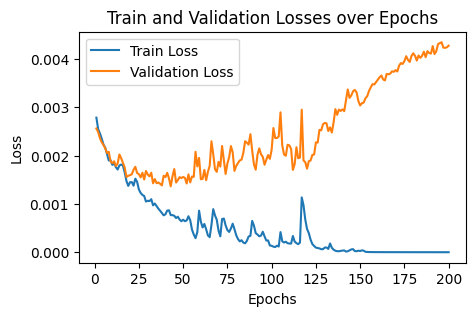

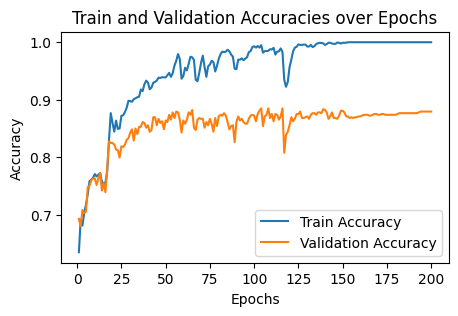

In [24]:
#Loss and accuracy plot
plot_losses(train_losses, valid_losses, config.EPOCH)
plot_accuracies(train_accuracies, valid_accuracies, config.EPOCH)

In [24]:
# 제일 성능이 좋은 모델 불러오기
model.load_state_dict(torch.load("/home/user/Desktop/bsh/absoluteA/model/2000_LSTM_best_model.pth"))
Macro_f1, auroc, accuracy, all_labels, all_probabilities = test(model, test_loader)
print(f"Best epoch: {best_epoch_save}")
print(f"macro F1 Score: {Macro_f1}")
print(f"AUROC: {auroc}")
print(f"Accuracy: {accuracy}")

100%|██████████| 3/3 [00:00<00:00, 456.78it/s]

Best epoch: 104
macro F1 Score: 0.8835870327481452
AUROC: 0.9161641342196898
Accuracy: 0.8837535014005602


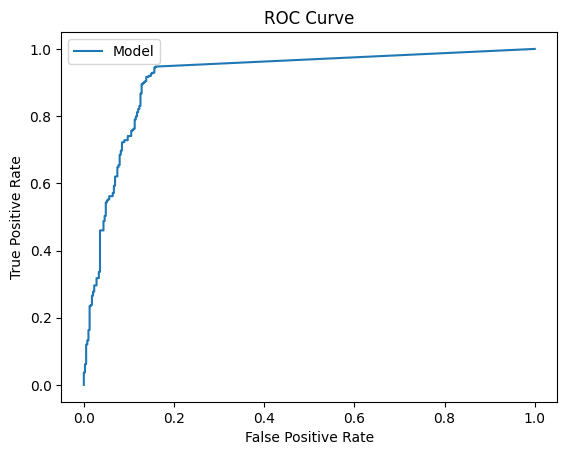

In [27]:
# AUROC plot
plot_roc_curve(all_labels, all_probabilities)